## Image segmentation with CamVid

In [1]:
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from nbdev.showdoc import *
from fastai.vision.widgets import *
import PIL.Image

In [3]:
path = Path('caries7')
path.ls()

(#7) [Path('caries7/.DS_Store'),Path('caries7/labels'),Path('caries7/annotations'),Path('caries7/images'),Path('caries7/models'),Path('caries7/codes.txt'),Path('caries7/._.DS_Store')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('caries7/images/00113.png'),Path('caries7/images/000104.jpg'),Path('caries7/images/00110.jpg')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('caries7/labels/0006_all_objects.png'),Path('caries7/labels/00264_all_objects.png'),Path('caries7/labels/00029_all_objects.png')]

<AxesSubplot:>

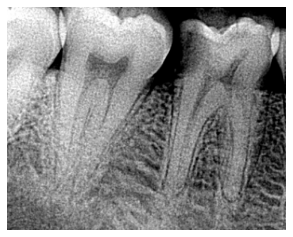

In [7]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_all_objects.png'

<AxesSubplot:>

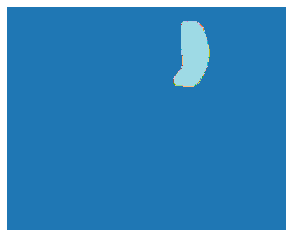

In [9]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([300]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Background', 'Caries', 'Void'], dtype='<U10')

## Datasets

In [12]:
size = (416)
bs=12

In [13]:
#valid_fnames = (path/'valid.txt').read().split('\n')

In [14]:
# export

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner


In [15]:
def get_y(o): return path/'labels'/f'{o.stem}_all_objects.png'
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.05),
                   get_y=get_y,
                   item_tfms=Resize(416, method='pad',pad_mode='zeros'), #Resize can also be passed inside of batch_tfms
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [16]:
dls = camvid.dataloaders(path/"images", bs=8, path=path)

<AxesSubplot:>

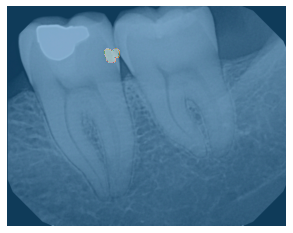

In [17]:
show_at(dls.train_ds, 0)

In [18]:
b = dls.train.one_batch()

In [19]:
b = dls.train.decode(b)

In [20]:
b[0].shape, b[1].shape

(torch.Size([8, 3, 416, 416]), torch.Size([8, 416, 416]))

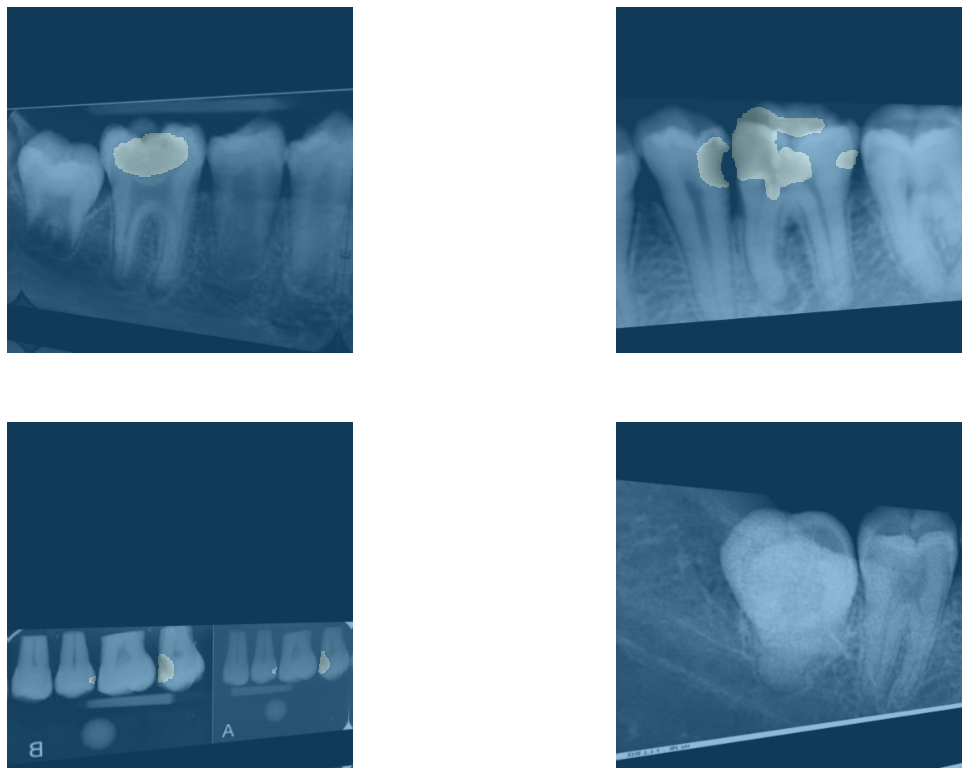

In [21]:
#vmin and vmax from https://forums.fast.ai/t/segmentationdataloaders-show-batch-not-showing-mask-in-other-color/66071/3 you resized the images manually you should try it with original sized images later
#vmin a nd vmax prob just need to be added to code later for show results
dls.show_batch(max_n=4, figsize=(20,14),vmin=0, vmax=1)

## Model

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid
# metrics=accuracy

In [24]:
wd=1e-2

In [25]:
dls.vocab = codes

In [26]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [27]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [28]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=3.630780702224001e-05)

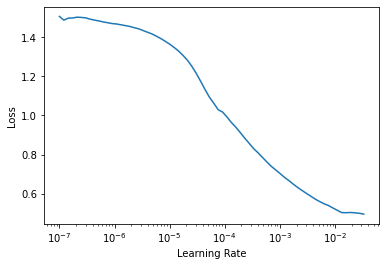

In [29]:
learn.lr_find()

In [30]:
lr=1e-3

In [31]:
learn.fit_one_cycle(12, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.150623,0.066689,0.988937,02:15
1,0.086426,0.048489,0.988943,02:08
2,0.061092,0.039798,0.988943,02:08
3,0.054111,0.041813,0.989790,02:08
4,0.048329,0.037694,0.989161,02:08
5,0.043598,0.069781,0.988975,02:08
6,0.042920,0.037174,0.989953,02:08
7,0.037121,0.034493,0.990837,02:07
8,0.036832,0.055753,0.991225,02:08
9,0.039281,0.027834,0.990891,02:07


In [32]:
learn.save('stage-1')

Path('caries7/models/stage-1.pth')

In [33]:
learn.load('stage-1');

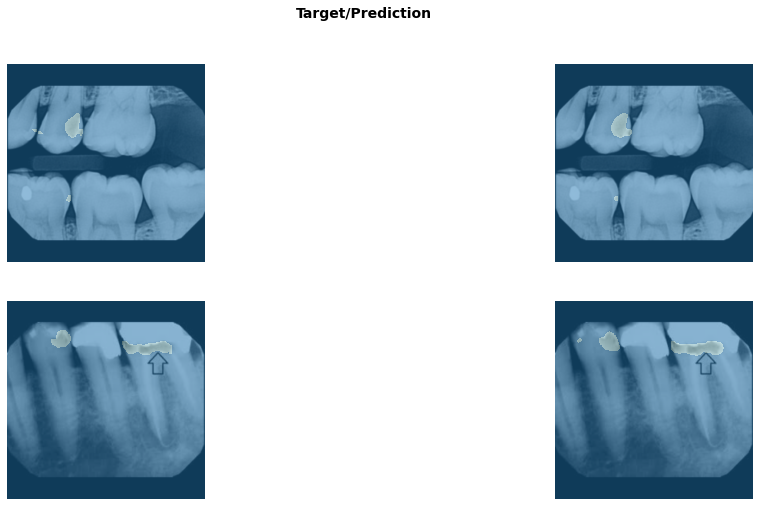

In [41]:
learn.show_results(max_n=4, figsize=(18,8), vmin=0, vmax=1)

In [35]:
learn.unfreeze()

In [36]:
lrs = slice(lr/400,lr/4)

In [43]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.013203,0.026985,0.993152,02:13
1,0.013590,0.026176,0.993079,02:12
2,0.012985,0.026755,0.993012,02:13
3,0.013477,0.026281,0.992750,02:12
4,0.013517,0.027218,0.993301,02:12
5,0.013138,0.028939,0.993548,02:12
6,0.014080,0.028448,0.992682,02:12
7,0.012888,0.028026,0.993308,02:12
8,0.013008,0.025707,0.992324,02:12
9,0.012747,0.027320,0.993254,02:12


In [38]:
learn.save('stage-2');

In [ ]:
learn.load('stage-2');

In [ ]:
learn.metrics = []

In [42]:
learn.export()

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('test.png')

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(416,416))
out_pl

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    outputs = learn_inf.predict(img)
    cm_hot = plt.get_cmap('tab10')
    masked = outputs[0].data
    im = np.array(masked)
    im = np.squeeze(im)
    im = cm_hot(im) 
    im = PIL.Image.fromarray((im*255).astype('uint8'))
    background=img.convert("RGBA")
    overlay=im.convert("RGBA")
    background=background.resize((416,416))
    overlay=overlay.resize((416,416))
    new_img = Image.blend(background, overlay, 0.5)
    with out_pl: display(new_img)

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
del learn
import gc
gc.collect()

In [ ]:
size = src_size
bs=3
#depending on your GPU RAM you may need to use
# bs=1
#print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
dls = camvid.dataloaders(path/"images", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls.vocab = codes

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(max_n=1, figsize=(20,10), vmin=1, vmax=30)

## fin